# Simple walkthrough

The heart of the DDM code (found in the `ddm_calc.py` file) is the computation of the image structure function. This is found by taking the average of the Fourier transforms of all image *differences*. By "image differences," I mean the result of subtracting two images separated by a given lag time $\Delta t$.

To describe the process mathematically, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y;t) - I(x,y;t + \Delta t)$$

For a given $\Delta t$ all such image differences are calculated. We then Fourier transform each $\Delta I$ and average all of the same $\Delta t$.

This results in the image structure function $D(q_x,q_y,\Delta t)$.

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

## Importing the necessary modules

### Modules for plotting
We use [matplotlib](https://matplotlib.org/) for creating figures and plots. Note that we use:
```python
%matplotlib inline
```
This sets the backend of matplotlib to `inline` which means the plots are included in the notebook. If you want the plots to also be interactive (e.g., having the ability to zoom, scroll, and save) then use:
```python
%matplotlib notebook
```

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Modules for numerical work
Here, we import [numpy](https://numpy.org/) and [xarray](https://xarray.pydata.org/en/stable/). 

Note that `xarray` might not have come with your Anaconda Python distribution (or whichever other distribution you installed). If that is the case, you'll need to [install](https://xarray.pydata.org/en/stable/getting-started-guide/installing.html) this package. 

In [33]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

### Import the PyDDM package
Make sure you append to `sys.path` the directory containing the [PyDDM](https://rmcgorty.github.io/PyDDM/) code. 

In [34]:
import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

## Initializing DDM_Analysis class and computing the DDM matrix
The instance of the `DDM_Analysis` class we create will need, when initialized, metadata about the images to analyze and the analysis and fitting parameters. This can be done by using a [yaml](https://yaml.org/) file as shown in the following cell of code (there, the metadata is saved in the file "*example_data_silica_beads.yml*". But one can also initialize `DDM_Analysis` with a dictionary containing the necessary metadata. One way to create such a dictionary and then using it to initialize `DDM_Analysis` is shown below. 
```python
import yaml
ddm_analysis_parameters_str = """
DataDirectory: 'C:/Users/rmcgorty/Documents/GitHub/DDM-at-USD/ExampleData/'
FileName: 'images_nobin_40x_128x128_8bit.tif'
Metadata:
  pixel_size: 0.242 # size of pixel in um
  frame_rate: 41.7 #frames per second
Analysis_parameters:
  number_lag_times: 40
  last_lag_time: 600
  binning: no 
Fitting_parameters:
  model: 'DDM Matrix - Single Exponential' 
  Tau: [1.0, 0.001, 10]
  StretchingExp: [1.0, 0.5, 1.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
  Good_q_range: [5, 20]
  Auto_update_good_q_range: True
"""
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)
ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)
```

In [35]:
#The yaml file `example_data_silica_beads.yml` contains the metadata and parameters above

ddm_calc = ddm.DDM_Analysis("example_data_silica_beads.yml")

Provided metadata: {'pixel_size': 0.242, 'frame_rate': 41.7}
Image shape: 3000-by-128-by-128
Number of frames to use for analysis: 999
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40
Applying binning...
Dimensions after binning (999, 64, 64), the new pixel size 0.484


Below, with the method `calculate_DDM_matrix`, we compute the DDM matrix and some associated data. The data will be stored as an [xarray Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) as an attribute to `ddm_calc` called `ddm_dataset`.

**Note**: There are a few optional arguments we can pass to `calculate_DDM_matrix`. There is an optional argument `quiet` (*True* or *False*, *False* by default). Then we have some optional keyword arguments (all of which could also be specified in the YAML file). These are: `overlap_method` which sets the degree of overlap between image pairs when finding all image differences for a each lag time and is either *0*, *1*, *2*, or *3*, `background_method` which sets how to estimate the background parameter *B* and is either *0*, *1*, *2*, or *3*, and `number_lag_times`. If any of these three keyword arguments are set here, the value specified in the YAML file will be overwritten. 

The file C:/Users/rmcgorty/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc already exists. So perhaps the DDM matrix was calculated already?
Do you still want to calculate the DDM matrix? (y/n): y


2022-03-23 13:58:18,556 - DDM Calculations - Running dt = 1...
2022-03-23 13:58:19,212 - DDM Calculations - Running dt = 5...
2022-03-23 13:58:19,653 - DDM Calculations - Running dt = 9...
2022-03-23 13:58:20,025 - DDM Calculations - Running dt = 16...
2022-03-23 13:58:20,324 - DDM Calculations - Running dt = 27...
2022-03-23 13:58:20,590 - DDM Calculations - Running dt = 47...
2022-03-23 13:58:20,833 - DDM Calculations - Running dt = 81...
2022-03-23 13:58:21,059 - DDM Calculations - Running dt = 138...
2022-03-23 13:58:21,283 - DDM Calculations - Running dt = 236...
2022-03-23 13:58:21,458 - DDM Calculations - Running dt = 402...


DDM matrix took 3.0278823375701904 seconds to compute.
 Background estimate ± std is 115.29 ± 5.60


<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 64, q_x: 64, q: 32, y: 64, x: 64, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -6.491 -6.288 -6.085 ... 5.882 6.085 6.288
  * q_x               (q_x) float64 -6.491 -6.288 -6.085 ... 5.882 6.085 6.288
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 5.882 6.085 6.288
  * y                 (y) int32 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * x                 (x) int32 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 53.61 52.11 ... 76.38 20.84
    ddm_matrix        (lagtime, q) float64 0.0 71.64 77.92 ... 137.0 123.0 102.7
    first_image       (y, x) float64 151.0 176.5 203.5 ... 234.5 197.8 199.0
    alignment_factor  (lagtime, q) float64 nan 6.123e-17 ... -0.01203 0.0433
    avg_image_ft      (q) float64 0.0 3.238e+04 1.004e+03 ... 61.42 56.82 54.71
    num_pairs_per_dt  (lagtime) int32 998 997 996 498 497 497 ... 7 6 5 4 3 2
    B                 float64 115.3
    B_std             float64 5.605
    Amplitude         (q) float64 -115.3 6.464e+04 1.893e+03 ... -1.662 -5.881
    ISF               (lagtime, q) float64 0.0 1.001 1.02 ... 5.634 -1.146
Attributes: (12/25)
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    ...                      ...
    split_into_4_rois:       False
    use_windowing_function:  False
    binning:                 True
    bin_size:                2
    central_angle:           None
    angle_range:             None

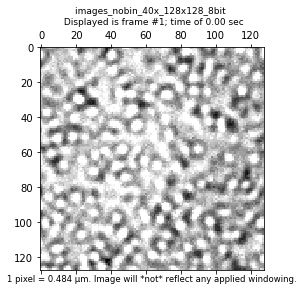

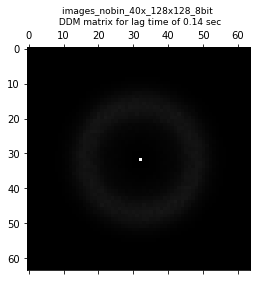

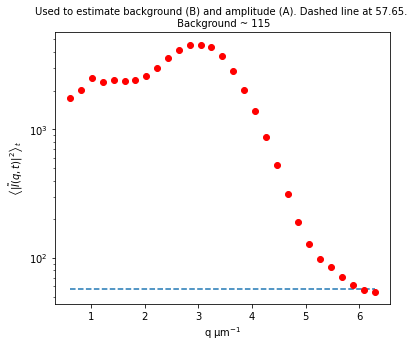

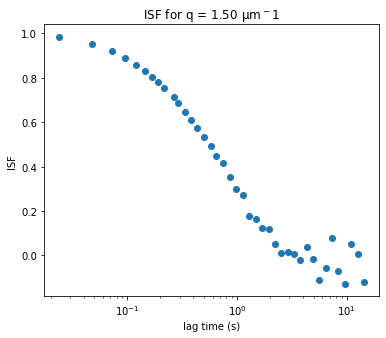

In [36]:
#If a file is found that matches what, by default, the program will save the computed DDM matrix as, 
#then you will be prompted as to whether or not you want to proceed with this calculation. If you 
#do not, then enter 'n' and the program will read from the existing file to load the DDM dataset 
#into memory. If you enter 'y', then the DDM matrix will be calculated.

ddm_calc.calculate_DDM_matrix()

## Finding variability in the DDM matrix

When computing the DDM matrix, we average over all pairs of images separated by the given set of lag times. For example, for a lag time of 2 frames, we will find the differences between frames 1 and 3, 2 and 4, 3 and 5, etc. The power spectrum of those differences are then taken to yield the DDM matrix. But what if the dynamics in the sample are changing? For example, perhaps the difference between frames 1 and 3 will be very different from the difference between frames 1001 and 1003. 

In [40]:
#tlags = ddm.ddm.generateLogDistributionOfTimeLags(1,800,512)
tlags = np.arange(1,998,dtype=int) #We will compute the DDM matrix for all lag times from 1 frame to 998 frames

#With the function 'variationInDDMMatrix', we compute the DDM matrix for the given lag times
# **without** doing any averaging over time. With the optional paramter 'save_full_ddmmat' set to 
# False, we will be radially averaging the 2D DDM matrix. This will save memory. 
ddm_variability = ddm_calc.variationInDDMMatrix(tlags, save_full_ddmmat=False)

In [68]:
ddm_variability.to_netcdf("ddm_variability_silicabeads.nc") #save generated dataset to disk

In [15]:
ddm_variability

<xarray.Dataset>
Dimensions:           (lagtime: 128, time: 2999, q: 32)
Coordinates:
  * time              (time) float64 0.0 0.02398 0.04796 ... 71.85 71.87 71.89
  * lagtime           (lagtime) int32 1 2 3 4 5 6 7 ... 351 360 369 379 389 400
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 5.882 6.085 6.288
Data variables:
    ddm_matrix        (lagtime, time, q) float64 0.0 220.0 184.4 ... nan nan nan
    alignment_factor  (lagtime, time, q) float64 nan 6.123e-17 ... nan nan
Attributes:
    AlignmentFactorAxis:  0

In [93]:
#We next construct a two-time correlation function  as a 2D array for a given
# wavenumber (q value)
qindex=18
num_frames = ddm_calc.im.shape[0]
twotimecorr = np.empty((num_frames,num_frames)); twotimecorr.fill(np.nan)
for t1 in range(num_frames):
    for i,lt in enumerate(ddm_variability.lagtime):
        t2 = t1 + lt
        if t2 < num_frames:
            twotimecorr[t1,t2] = ddm_variability.ddm_matrix[i,t1,qindex]

<IPython.core.display.Javascript object>


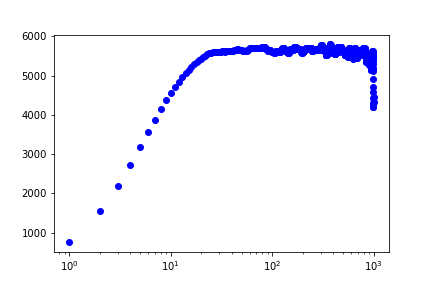

In [94]:
fig,ax = plt.subplots()
#ax.semilogx(ddm_variability.lagtime, ddm_variability.ddm_matrix[:,:,30].mean(axis=1),'ro')
ax.semilogx(ddm_variability.lagtime, ddm_variability.ddm_matrix[:,:,18].mean(axis=1),'bo')

In [43]:
%matplotlib notebook

In [95]:
ddm_variability.q[18]

<xarray.DataArray 'q' ()>
array(3.65112783)
Coordinates:
    q        float64 3.651

In [96]:
twotimecorr2 = np.fliplr(twotimecorr)
twotimecorr2 = np.rot90(twotimecorr2)

twotimecorr_tot = np.empty((2,twotimecorr.shape[0],twotimecorr.shape[1]))
twotimecorr_tot[0] = twotimecorr
twotimecorr_tot[1] = twotimecorr2

twotimecorr_total = np.nansum(twotimecorr_tot, axis=0)

for i in range(twotimecorr_total.shape[0]):
    twotimecorr_total[i,i] = np.nan

<IPython.core.display.Javascript object>


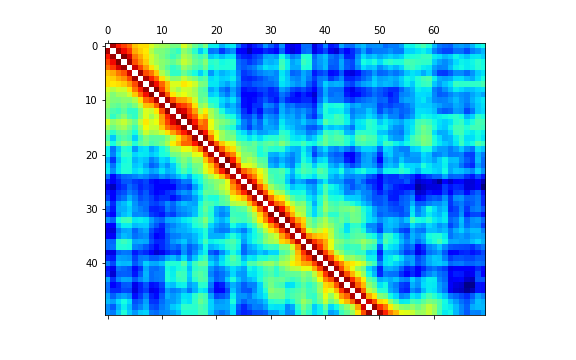

In [100]:
plt.figure(figsize=(8,5))
plt.matshow(twotimecorr_total[0:50,0:70], cmap='jet_r', fignum=0)
plt.savefig("twotimecorr_qindex18_q3.65_zoom.png")

In [107]:
variations = np.empty((len(ddm_variability.lagtime), len(ddm_variability.time)))
variations.fill(np.nan)

skewnesses = np.empty(len(ddm_variability.lagtime))

for i in range(len(ddm_variability.lagtime)):
    variations[i] = ddm_variability.ddm_matrix[i,:,q_index]**2 - np.nanmean(ddm_variability.ddm_matrix[i,:,q_index])**2
    skewnesses[i] = np.nanmean(variations[i]**3) / (np.nanmean(variations[i]**2)**1.5)


In [25]:
skewnesses

array([1.37101269, 1.23325105, 1.27013365, 1.22294285, 1.21104983,
       1.13181255, 1.26140114, 1.32001022, 1.12055991, 1.23361749])

<IPython.core.display.Javascript object>


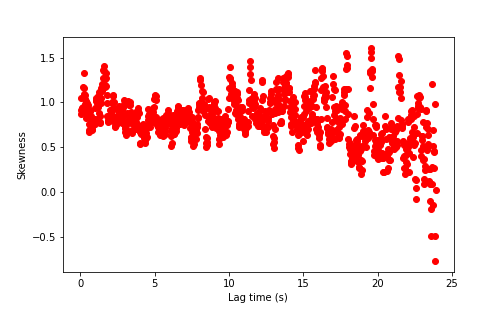

In [110]:
fig,ax = plt.subplots(figsize = (7,7/1.618))
ax.plot(ddm_variability.lagtime / 41.7, skewnesses, 'ro')
ax.set_xlabel("Lag time (s)")
ax.set_ylabel("Skewness")
plt.savefig("DDMMat_hist_q18_lag10.png")

<IPython.core.display.Javascript object>


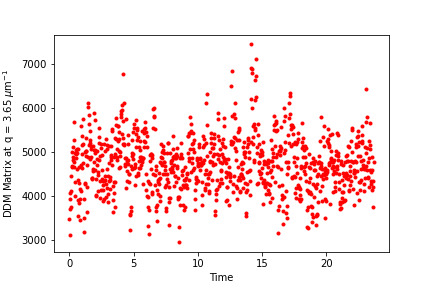

<IPython.core.display.Javascript object>


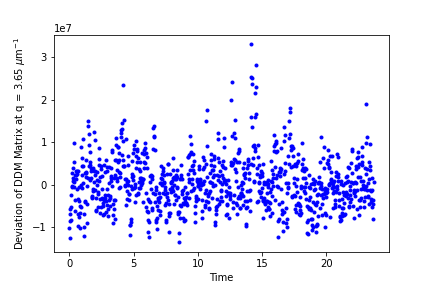

<IPython.core.display.Javascript object>


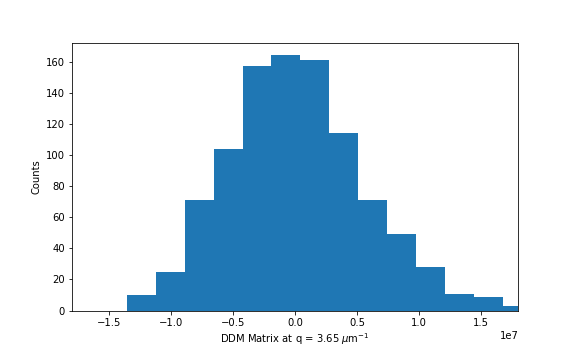

Skewness: 1.0917


In [106]:
fig,ax = plt.subplots()
q_index = 18
lagtimeindex = 10
ax.plot(ddm_variability.time, ddm_variability.ddm_matrix[lagtimeindex,:,q_index], 'r.')

ax.set_xlabel("Time")
ax.set_ylabel("DDM Matrix at q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index])

fig,ax = plt.subplots()

variation = ddm_variability.ddm_matrix[lagtimeindex,:,q_index]**2 - np.mean(ddm_variability.ddm_matrix[lagtimeindex,:,q_index])**2
ax.plot(ddm_variability.time, variation, 'b.')
ax.set_xlabel("Time")
ax.set_ylabel("Deviation of DDM Matrix at q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index])

fig,ax = plt.subplots(figsize = (8,8/1.618))
plt.hist(variation, bins=20)
ax.set_xlabel("DDM Matrix at q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index])
ax.set_ylabel("Counts")
ax.set_xlim(-1.8e7,1.8e7)
plt.savefig("DDMMat_hist_q18_lag10.png")

skewness = np.mean(variation**3) / (np.mean(variation**2)**1.5)
print("Skewness: %.4f" % skewness)

## Initiazing DDM_Fit class and fitting our data to a model
Next, we initialize the `DDM_Fit` class which will help us fit the calculated DDM matrix to a model of our choosing. 

When the `DDM_Fit` class is initialized, it will display a table of the parameters, with the initial guesses and bounds, that were in the parameters of the yaml file. It will also indicate if, for the chosen model, initial guesses for parameters are missing. 

<div class="alert alert-block alert-info">
<b>Note:</b> The intial guesses and bounds for the parameters are given in the yaml file. But you may realize that you need to adjust the bounds. You could change the yaml file and reload it. But you can also change the initial guesses and bounds for the parameters as shown in this code snippet:
</div>

```python
ddm_fit.set_parameter_initial_guess('Tau', 0.5)
ddm_fit.set_parameter_bounds('Tau', [0.001, 1000])
```

Also, note that to initialize the `DDM_Fit` class, we need to pass it the YAML file which contains the metadata and parameters. Below, we use the fact that the path to the YAML file is stored in the variable `ddm_calc.data_yaml`. But we could also use the path to the YAML file just like we did when initializing the DDM_Analysis class. That is, this would work as well:

```python
ddm_fit = ddm.DDM_Fit("../../Examples/example_data_silica_beads.yml")
```

In [6]:
ddm_fit = ddm.DDM_Fit(ddm_calc.data_yaml)

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,1.1


Loading file C:/Users/rmcgorty/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc ...


Below, the fit is performed and saved into an xarray Dataset. We also have a table of the parameters for each q. Since this table may be long (especially if you have a large image size), you might want to not display it. If that's the case, then run this command with the `display_table` parmeter set to False, i.e.:
```python
fit01 = ddm_fit.fit(name_fit = 'fit01', display_table=False)
```

In [7]:
#Note that the method `fit` has many optional parameters, but here we 
# allow those optional parameter to take their default values

fit01 = ddm_fit.fit()

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.


,q,Amplitude,Tau,Background,StretchingExp
0,0.000000,1.000000,10.000000,0.000000,1.100000
1,0.202840,5009.160959,10.000000,125.265537,0.500000
2,0.405681,8482.808495,10.000000,0.000000,0.525256
3,0.608521,10442.590957,3.868067,110.613248,0.710762
4,0.811362,16595.852548,2.556070,83.269636,0.811578
5,1.014202,18774.162108,1.424364,101.316228,0.909133
6,1.217043,20126.206549,1.035536,37.943122,0.911751
7,1.419883,20269.935277,0.742219,30.165661,0.952913
8,1.622723,19408.933976,0.552100,0.000000,0.955882
9,1.825564,21442.103307,0.465083,0.000000,0.977973


### Inspecting the outcome of the fit

We can now take a look at the best fit parameters determined by the fitting code. We can generate a set of plots and have the output saved as PDF with the function `fit_report`. This takes a few arguments, including:
* the result of the fit in an xarray Dataset (here `fit01`)
* `q_indices`: the DDM matrix or the ISF (whichever was used in the fitting) will be plotted at these $q$-values specified by their index in the array of $q$-values
* `forced_qs`: range of $q$-values (specified, again, by the index) for which to extract power law relationship between the decay time $\tau$ and $q$

In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 5.009e+03 ... 0.9077 0.9903
    theory           (lagtime, q) float64 0.001311 364.7 349.3 ... 206.3 206.3
    isf_data         (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
    ddm_matrix_data  (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    A                (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    B                float64 211.2
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.616760567419975
    tau_vs_q_slope:                 [-1.9799845]
    msd_alpha:                      [1.01010892]
    ...                             ...
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               0
    OverlapMethod:                  2

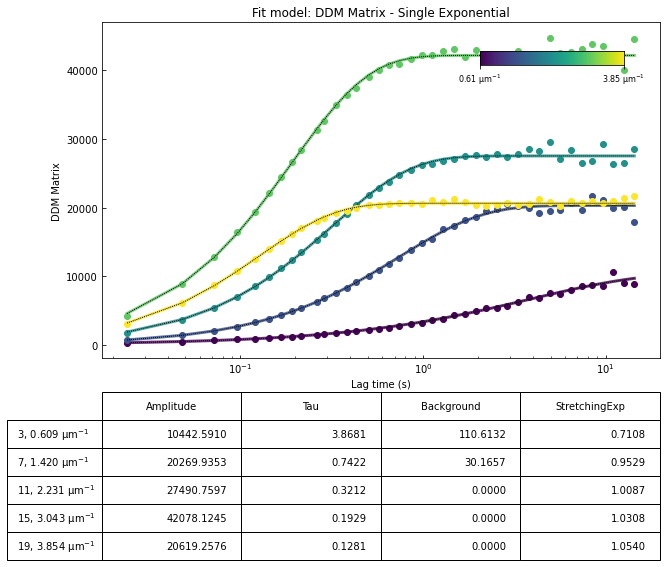

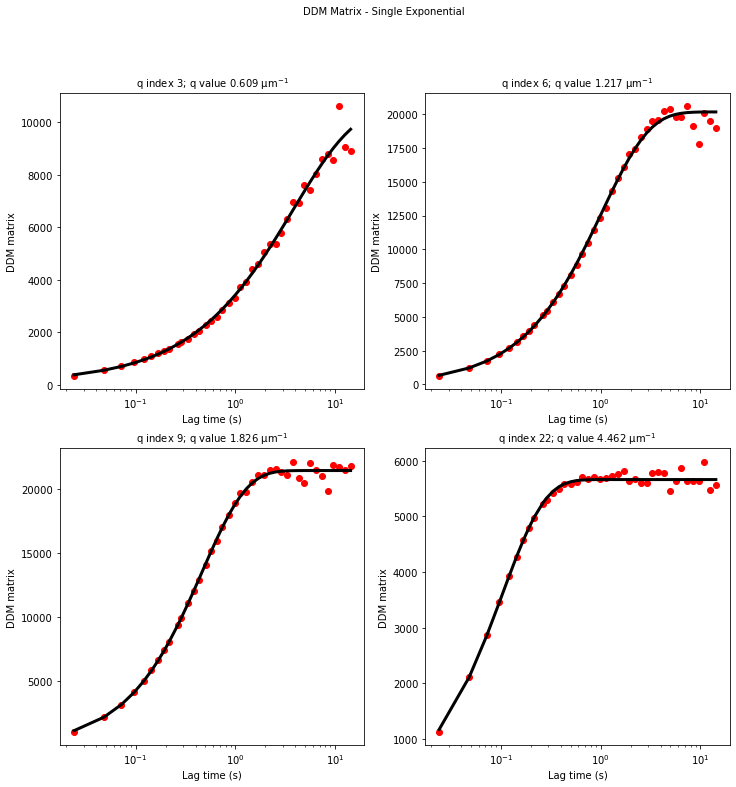

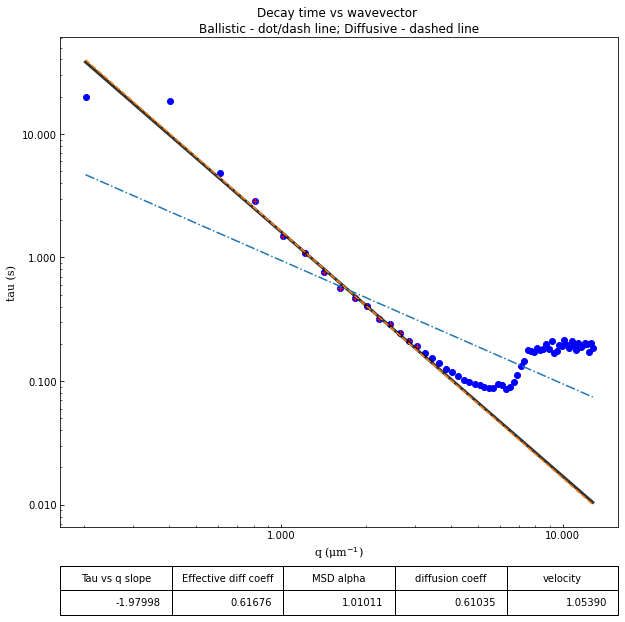

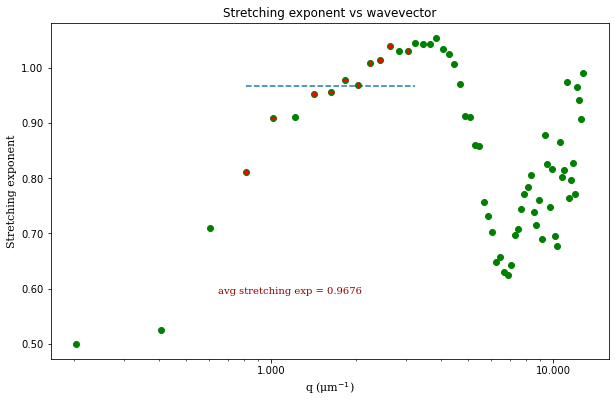

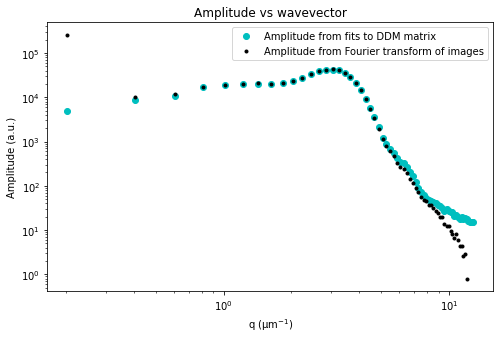

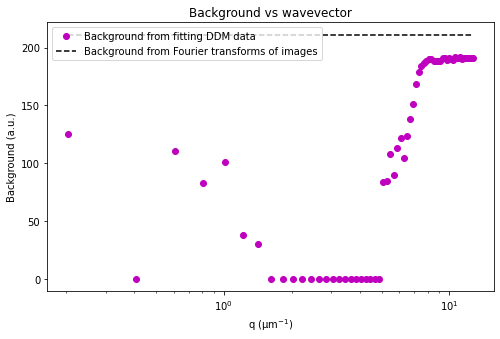

In [8]:
ddm.fit_report(fit01, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

### Trying a different mathematical model
Above, we fit the DDM matrix to a model where the intermediate scattering function (ISF or $f(q,\Delta t)$) is an exponential. That is, we fit our data to:
$$ D(q,\Delta t) = A(q) \left[ 1 - \exp \left(-\Delta t / \tau(q) \right) ^{s(q)} \right] + B(q)$$
where $A$ is the amplitude, $B$ is the background, $\tau$ is the decay time, and $s$ is the stretching exponent. 

An alternative is to use other information to determine $A(q)$ and $B$ and then fit only the ISF. We will try this below.

In [9]:
ddm_fit.reload_fit_model_by_name("ISF - Single Exponential")

,Initial guess,Minimum,Maximum
Tau,1.0,0.001,10.0
StretchingExp,1.0,0.500,1.1


In [10]:
fit02 = ddm_fit.fit(display_table=False)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit02'.


In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 2, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Tau' 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 0.001886 10.0 10.0 ... 1.1 1.093
    theory           (lagtime, q) float64 4.761e-07 0.9987 0.9812 ... 0.0 0.0
    isf_data         (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
    ddm_matrix_data  (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    A                (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    B                float64 211.2
Attributes: (12/18)
    model:                          ISF - Single Exponential
    data_to_use:                    ISF
    initial_params_dict:            ["{'n': 0, 'value': 1.0, 'limits': [0.001...
    effective_diffusion_coeff:      0.6044361168424172
    tau_vs_q_slope:                 [-1.97401294]
    msd_alpha:                      [1.01316459]
    ...                             ...
    DataDirectory:                  C:/Users/rmcgorty/Documents/GitHub/PyDDM/...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               0
    OverlapMethod:                  2

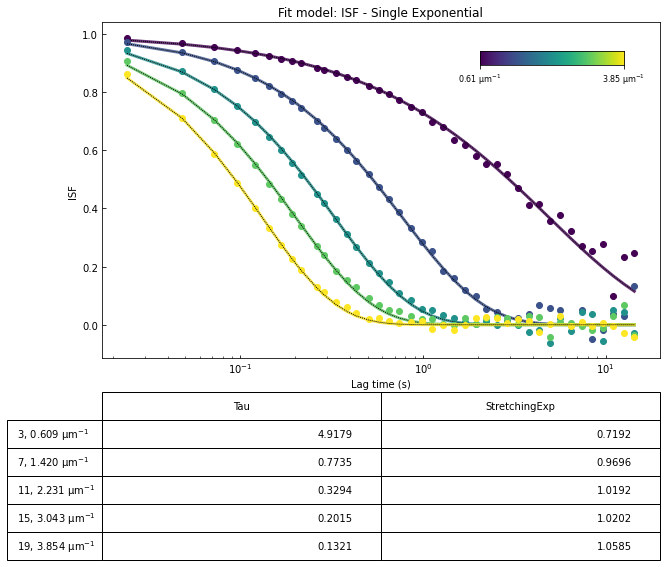

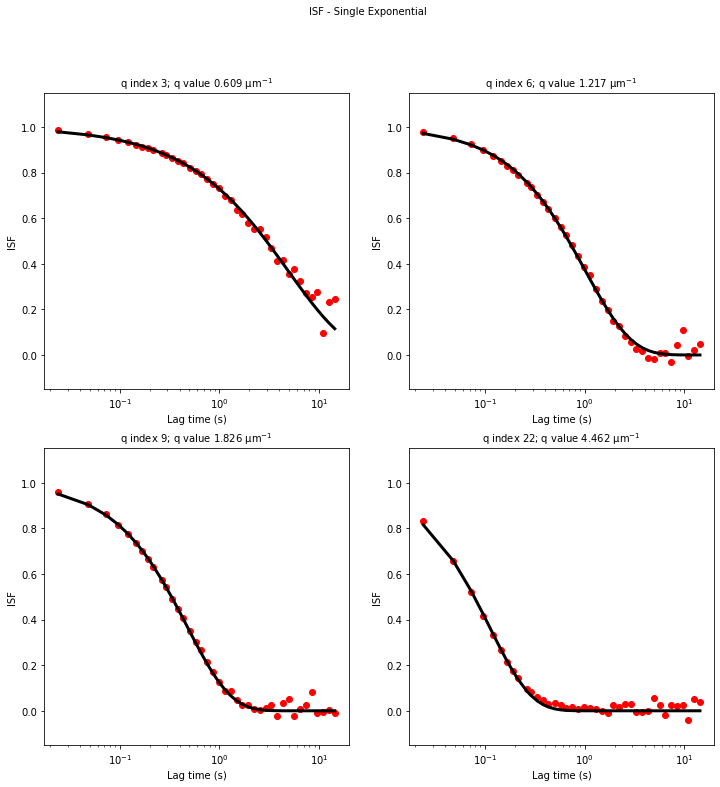

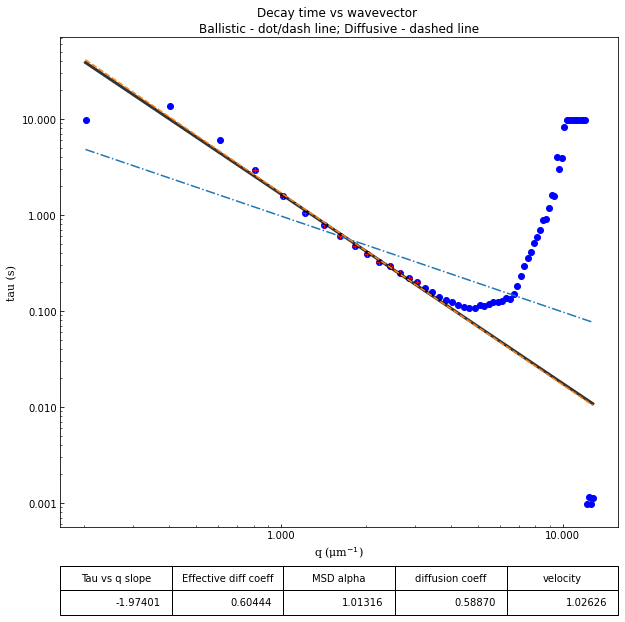

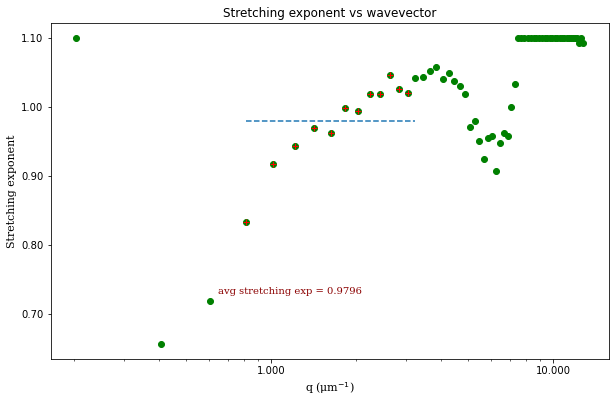

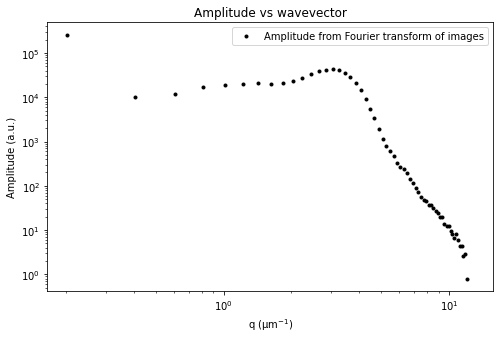

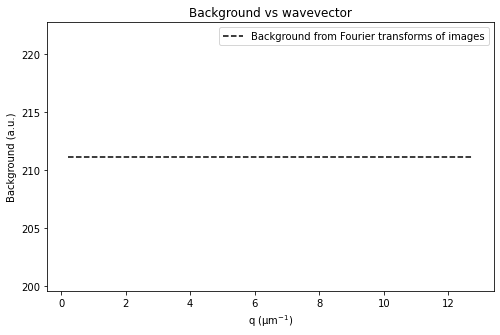

In [11]:
ddm.fit_report(fit02, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

## Interactive with matplotlib

Using the `Browse_DDM_Fits` class as shown below, one can interactively inspect the fits (to either the DDM matrix or the ISF) by selecting the appropriate point on the $\tau$ vs $q$ plot or by pressing 'N' or 'P' for next or previous. 

<IPython.core.display.Javascript object>


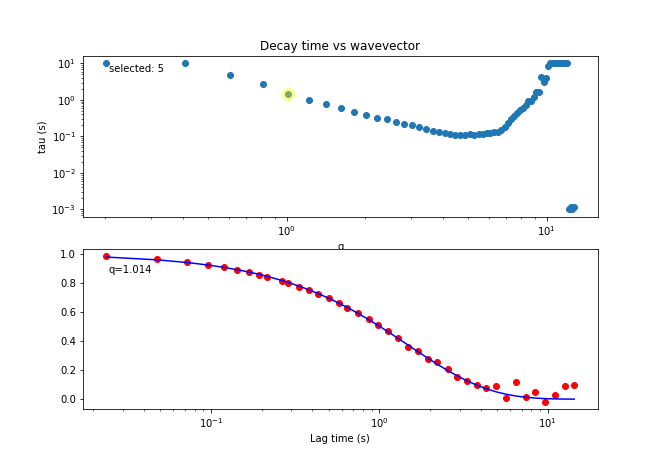

Click on a point in the tau vs q plot to see a fit.
Or press 'N' or 'P' to display next or previous fit.


Text(0, 0.5, 'tau (s)')

In [12]:
%matplotlib notebook
fig, (ax, ax2) = plt.subplots(2, 1)
browser = ddm.Browse_DDM_Fits(fig, ax, ax2, fit02)

fig.canvas.mpl_connect('pick_event', browser.on_pick)
fig.canvas.mpl_connect('key_press_event', browser.on_press)

ax.set_title('Decay time vs wavevector')
ax.set_xlabel("q")
ax.set_ylabel("tau (s)")

## Saving the results

We have a few options for saving the results of the fit. We can save the information contained in the xarray Dataset `fit01` as an Excel file. Or we can save it as a netCDF file using the xarray function [`to_netcdf`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html). If we have the fit results as a netCDF file, then we can reload it easily with the xarray function [`open_dataset`](https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html). 

In [13]:
ddm.save_fit_results_to_excel(fit01)

In [14]:
fit01.to_netcdf("example_netcdf_file.nc")

In [15]:
loaded_netcdf_file = xr.open_dataset("example_netcdf_file.nc")